# Boilerplate

In [1]:
# python internal 
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
print(os.getcwd())
import random
import re
import socket
print(socket.gethostname())
import shutil
import subprocess
import sys
# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta
# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

/mnt/home/pleung/projects/bistable_bundle/r3/hinges
dig37


# Flo's original approach:
4. now it gets even worse. I use`/home/flop/switch/5thround/DHRs/loops/score_to_loop.ipynb` to generate cmds for loop closure. have a look, and then we should probably talk about it. it is messy.
	
basically I first try to find loops that match the original DHR, for example
in: `/home/flop/switch/5thround/DHRs/loops/match_orig_d6_04/`

because this doesn't work for all of them, I also re-loop the original DHRs,
also sampling truncations and extensions of the helices before and after the
new loop

i exhaustively did that for all dhrs in my input set: 
`/home/flop/switch/5thround/DHRs/loops/x_ind_all_te`

then I try to find loops in the new states that match the outputs of the state
x relooping: `/home/flop/switch/5thround/DHRs/loops/match_ind_d6/`

I design the loops (incl. neighborhood): 
`/home/flop/switch/5thround/DHRs/loops/des*`
(path names kinda match the ones from loop closure)

# I will follow Flo's looping procedure with some changes.
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.
I might try using Hugh's 19A refit weights/scorefunction, as well as `beta_nov16` to compare their efficacy.  
I will try the following hierarchy of closure methods: 
1. close using identical length loop and no adjustment with connect chains mover (CCM) at 0.8 RMS (total length and SS match)
2. close using identical length loop and +/-2 res adjustment with CCM at 0.4 RMS (total length match, potential SS mismatch)
3. close using many non identical length loops and searching for length and optionally abego and SS matches, using CCM at 0.4 RMS 
4. if needed, close using blueprint/remodel approach and search for length and optionally abego and SS matches

For matching, will try to always find matches for State A as the initial, parent DHR, as this is the gold standard for a reference state.

Depending on how many matches there are, this might already be enough.

TODO sequence recovery of parent as a final metric in 04?

# Make functions for looping and labeling to assist downstream penultimate design step

In [4]:
def load(silent, **kwargs):
    import pyrosetta.distributed.io as io
    if silent == None:
        silent = kwargs["-in:file:silent"]
    pposes = io.poses_from_silent(silent)
    for ppose in pposes:
        yield ppose

In [3]:
def close(ppose, **kwargs):
    """CLose with TJ's ConnectChains mover. kwargs optional, will attempt to match parent in the 
    absence of kwargs options for the mover"""
    import os
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    # get parent from ppose, get loop length from parent length - ppose length
    scores_dict = ppose.pose.scores
    if "length" not in kwargs:
        parent_length = int(scores_dict["parent_length"]) # TODO add this as custom score
        length = int(parent_length - len(ppose.pose.residues))
    else:
        length = int(kwargs["length"])
    # get custom options, set default, strict options if no custom options are provided
    if "adj1" or "adj2" in kwargs:
        print(kwargs)
        try:
            assert "adj1" and "adj2" in kwargs
        except:
            RuntimeError, "need to provide both adj1 and adj2, or else will use 0 adjustment range"
        else:
            adj1, adj2 = kwargs["adj1"], kwargs["adj2"]
            rms = 0.4
    else:
        adj1, adj2 = 0, 0
        rms = 0.8 # TODO
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" /> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>          
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <MOVERS>
            <ConnectChainsMover name="closer" 
                chain_connections="[A+B]" 

                loopLengthRange="2,5" 
                resAdjustmentRangeSide1="-2,2" 
                resAdjustmentRangeSide2="-2,2" 
                RMSthreshold="0.8"/> 
                #allowed_loop_abegos="AGBA,ABBA,AGBBA,ABABA,ABBBA,AGABBA,ABBBBA,AGBBBA"/> # TODO
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <PROTOCOLS>
            <Add mover_name="closer"/>
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """#.format(lower=length-1, upper=length+1, adj1=adj1, adj2=adj2, rms=rms)
                # loopLengthRange="{lower},{upper}" 
                # resAdjustmentRangeSide1="{adj1},{adj1}" 
                # resAdjustmentRangeSide2="{adj2},{adj2}" 
                # RMSthreshold="{rms}" 
    closer = SingleoutputRosettaScriptsTask(xml)
    
    closed_ppose = closer(ppose.pose.clone())
    closed_pose = io.to_pose(closed_ppose)
    for key, value in scores_dict.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(closed_pose, key, value)
    final_ppose = io.to_packed(closed_pose)
#     yield final_ppose
    return final_ppose

In [20]:
from pyrosetta.distributed.packed_pose.core import PackedPose

def remodel(ppose: PackedPose, **kwargs):
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="remodel_cen" /> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>          
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <MOVERS>
            <RemodelMover name="bdr" blueprint="test.bpt"/>      
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <PROTOCOLS>
            <Add mover_name="bdr"/>
        </PROTOCOLS>
    </ROSETTASCRIPTS>

    """
    remodeled = SingleoutputRosettaScriptsTask(xml)
    
    remodeled_ppose = remodeled(ppose.pose.clone())
    return remodeled_ppose

In [ ]:
import pyrosetta.distributed.io as io
pyrosetta.init("")# -restore_pre_talaris_2013_behavior")
test = io.pose_from_file("dummy.pdb")
temp_built = remodel(test)

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.import_pose.import_pose: {0} File 'dummy.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] discarding 3 atoms at position 2 in file dummy.pdb. Best match rsd_type:  GLY:CtermProteinFull
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue GLY:CtermProteinFull 2
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] can't find pose atom for file-residue 2 atom 1H   (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] can't find pose atom for file-residue 2 atom 2H   (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFr

In [ ]:
# options = { #     "-multithreading:total_threads": "1", # TODO remove? # TODO add 19A wts and flags?
#     "-out:level": "300",
#     "-in:file:silent_struct_type": "binary",
#     "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
# #     "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5", # TODO need different database
#     "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
#     "-corrections::beta_nov16": "true",
#     "-dunbrack_prob_buried": "0.8",
#     "-dunbrack_prob_nonburied": "0.8", 
#     "-dunbrack_prob_buried_semi": "0.8", 
#     "-dunbrack_prob_nonburied_semi": "0.8",
# }
# flags = " ".join(" ".join([key, value]) for key, value in options.items())
# pyrosetta.init(flags)
# i = 0
# for ppose in load("../01_make_states/DHR53_derived.silent"):
#     i += 1
# #     print(ppose.pose.sequence())
#     try:
#         close(ppose, length=4).pose.dump_pdb("test_2_{}.pdb".format(i))
#     except:
#         print("error")
#         continue
#     else:
# #         tclose.pose.dump_pdb()
#         pass

In [43]:
def label(ppose, **kwargs):
#     import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    from pyrosetta.rosetta.core.select import get_residues_from_subset
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects 
    
    def find_vv(seq):
        indices = []
        seq_minus_one = seq[:-1]
        for i, char in enumerate(seq_minus_one):
            if (char == seq[i+1]) and (char == "V"):
                indices.append(i+1)
            else:
                pass
        # rosetta sequence indexes begin at 1
        true_indices = [str(x+1) for x in indices]
        return true_indices
    
    seq = str(ppose.pose.sequence())
    vv_indices = ",".join(find_vv(seq))
    scores_dict = ppose.pose.scores
    pivot_helix = int(scores_dict["pivot_helix"]) # TODO add this custom score
    pre_break_helix = int(scores_dict["pre_break_helix"]) # TODO add this custom score
    if pivot_helix == pre_break_helix:
        lower = pivot_helix - 1
        upper = pivot_helix + 2
    else:
        lower = pre_break_helix - 1
        upper = pivot_helix + 1
        
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" /> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <SSElement name="middle" selection="{lower},H,E" to_selection="{upper},H,S" chain="A" reassign_short_terminal_loop="2" />
            <Index name="polyval_all" resnums="{vv_indices}" />
            <And name="polyval" selectors="middle,polyval_all" />
            <PrimarySequenceNeighborhood name="entire_val" selector="polyval" lower="5" upper="5" />
            <SecondaryStructure name="loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" use_dssp="true" ss="L"/>
            <And name="new_loop_center" selectors="entire_val,loop" />
            <PrimarySequenceNeighborhood name="entire_new_loop_broad" selector="new_loop_center" lower="5" upper="5" />
            <ResidueName name="isval" residue_name3="VAL" />
            <And name="entire_new_loop" selectors="entire_new_loop_broad,isval" />
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <MOVERS>
            <AddResidueLabel name="add_loop_label" residue_selector="entire_new_loop" label="new_loop" />  
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <PROTOCOLS>
            <Add mover="add_loop_label" />
        </PROTOCOLS>
        #OUTPUT scorefxn="sfxn" />
    </ROSETTASCRIPTS>
    """.format(lower=lower, upper=upper, vv_indices=vv_indices)
    labeled = SingleoutputRosettaScriptsTask(xml)
    xml_obj = XmlObjects.create_from_string(xml)
    entire_new_loop_sel = xml_obj.get_residue_selector("entire_new_loop")
    labeled_ppose = labeled(ppose.pose.clone())
    labeled_pose = io.to_pose(labeled_ppose)
    new_loop_resis = list(get_residues_from_subset(entire_new_loop_sel.apply(labeled_pose)))
    new_loop_str = ",".join(str(resi) for resi in new_loop_resis)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, "new_loop_resis", new_loop_str)
    # TODO add loop_length, loop_ABEGOS to scores
    for key, value in scores_dict.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, key, value)
    final_ppose = io.to_packed(labeled_pose)
    return final_ppose

In [ ]:
# seqs = []
# pyrosetta.init("-corrections::beta_nov16 true")
# for pdb in glob("./*.pdb"):
#     pose = io.to_pose(io.pose_from_file(pdb))
#     seqs.append(str(pose.sequence()))
#     pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "pre_break_helix", 4.0)
#     pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "pivot_helix", 5.0)
#     ppdb = io.to_packed(pose)
#     labeled = label(ppdb)
#     print(labeled.pose)
#     print(labeled.pose.scores)

# Setup Dask
Trying a adaptive SLURMCluster. to see the dashboard, forward port `8787` to `8000`:  
`local$ ssh -L 8000:localhost:8787 $USER@$HOSTNAME`  
now, the web UI is visible at `localhost:8000`  
if you're using a local cluster make sure the node this notebook is on has the same 
number of workers as cores

In [4]:
!echo $HOSTNAME
!echo $USER

dig28
pleung


In [38]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

scratch_dir = os.path.join("/net/scratch", os.environ["USER"])
cluster = SLURMCluster(cores=1,
                       processes=1,
                       job_cpu=1,
                       memory="8GB",
                       queue="medium",
                       # TODO check if these two are neccessary
                       walltime="23:30:00",
                       death_timeout=600,
                       # write .out files to scratch, remember to delete them later
                       local_directory=scratch_dir,
                       job_extra=["-o {}".format(os.path.join(scratch_dir, "slurm-%j.out"))]
                      )
print(cluster.job_script())
# scale between 0 and 1000 workers as needed
cluster.adapt(minimum=0, maximum=1000) 
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=8G
#SBATCH -t 23:30:00
#SBATCH -o /net/scratch/pleung/slurm-%j.out

/home/pleung/.conda/envs/cereal/bin/python -m distributed.cli.dask_worker tcp://172.16.131.66:44541 --nthreads 1 --memory-limit 8.00GB --name name --nanny --death-timeout 600 --local-directory /net/scratch/pleung



Client Scheduler: tcp://172.16.131.66:44541 Dashboard: http://172.16.131.66:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [8]:
# client.close(); cluster.close()

# Set command line options, make tasks and submit to client

In [10]:
import logging
import pyrosetta.distributed.io as io
from pyrosetta.distributed.cluster.core import PyRosettaCluster

logging.basicConfig(level=logging.INFO)

silents = glob(os.path.join(os.getcwd().replace("02_design_and_filter",""),"01_make_states/*.silent"))
silents = silents[-1:] # TODO just test some for now

options = { #     "-multithreading:total_threads": "1", # TODO remove? # TODO add 19A wts and flags?
    "-out:level": "300",
    "-in:file:silent_struct_type": "binary",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
    "-corrections::beta_nov16": "true",
    "-dunbrack_prob_buried": "0.8",
    "-dunbrack_prob_nonburied": "0.8", 
    "-dunbrack_prob_buried_semi": "0.8", 
    "-dunbrack_prob_nonburied_semi": "0.8",
}

def create_tasks(options):
    for silent in silents:
        tasks = {
            "options": "-ex1", # TODO check if this works with only extra_options
            "extra_options": options,
            "set_logging_handler": "interactive",
            "-in:file:silent": os.path.join(os.getcwd(),silent),
        }
        yield tasks
        
if not os.getenv("DEBUG"):
    output_path = os.path.join(os.getcwd(), "designed_beta_nov16")

    PyRosettaCluster(
        tasks=create_tasks(options),
        client=client,
        scratch_dir=output_path,
        output_path=output_path,
        nstruct=5,
        sha1=None, # TODO setup git, also eventually want to ensure a conda env is dumped
    ).distribute(protocols=[load, design, score])

`conda env export --prefix /home/pleung/.conda/envs/cereal > environment.yml`
to reproduce this simulation later.
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/cereal/lib/python3.7/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


https://docs.anaconda.com/anaconda/install



# Look at scores
TODO there is certainly a less embarrassing way to do this

In [16]:
output_path = os.path.join(os.getcwd(), "designed_beta_nov16")
scores = pd.read_json(os.path.join(output_path, "scores.json"), orient="records", typ="frame", lines=True)
scores = scores.T
mat = scores.values
n = mat.shape[0]
dicts = list(mat[range(n), range(n)])
index = scores.index
new_scores = pd.DataFrame(dicts, index=index)
new_scores.head()

,bb_clash,ddg,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,...,sc_int,score,score_A,score_B,score_per_res,shift,total_score,wnm_A,wnm_B,wnm_all
/mnt/home/pleung/projects/bistable_bundle/r3/02_design_and_filter/designed_beta_nov16/decoys/0000/2021.01.14.20.53.11.016731_7f9b3e653a8d4bf7923de9006bc46d0e.pdb.bz2,134.072998,-51.490948,0.0,-2827.646278,71.498605,383.103123,519.690197,-960.879389,-184.483757,-75.305954,...,0.800696,0.0,-236.635086,-575.988464,-2.824289,7.0,-1245.511566,0.532146,0.550318,1.304184
/mnt/home/pleung/projects/bistable_bundle/r3/02_design_and_filter/designed_beta_nov16/decoys/0000/2021.01.14.20.53.11.016731_a657e260928e424daa632cba8b023cd7.pdb.bz2,134.072998,-56.948582,0.0,-2841.624763,72.756739,378.260713,525.594015,-971.775624,-185.889270,-78.023735,...,0.817188,0.0,-240.678558,-577.300781,-2.818640,3.0,-1243.020001,0.575764,0.561258,1.456395
/mnt/home/pleung/projects/bistable_bundle/r3/02_design_and_filter/designed_beta_nov16/decoys/0000/2021.01.14.20.53.11.016731_2d159dd816174c54b29457a44f6eb2e0.pdb.bz2,9476.634766,-19.511942,0.0,-2792.369425,78.471203,365.879012,495.879217,-937.216955,-179.105688,-72.858884,...,0.763358,0.0,-232.192871,-582.372925,-2.753024,4.0,-1214.083403,0.562699,0.551855,1.849492
/mnt/home/pleung/projects/bistable_bundle/r3/02_design_and_filter/designed_beta_nov16/decoys/0000/2021.01.14.20.53.11.016731_eaef503e72204afdb9c14539f4f1441c.pdb.bz2,134.072998,-82.301064,0.0,-2837.295715,73.738920,385.817082,517.644353,-965.408321,-185.644223,-76.838702,...,0.827833,0.0,-232.913376,-579.345642,-2.865920,7.0,-1263.870891,0.539629,0.559252,1.371720
/mnt/home/pleung/projects/bistable_bundle/r3/02_design_and_filter/designed_beta_nov16/decoys/0000/2021.01.14.20.53.11.016731_33a0712a640e4c6393107d9cf01123ae.pdb.bz2,134.072998,-72.724785,0.0,-2863.356861,71.480414,378.583537,515.711490,-953.393592,-185.391249,-77.870458,...,0.800647,0.0,-241.334122,-574.142639,-2.919992,-7.0,-1287.716418,0.581327,0.553716,1.700490


# Analyze some scoreterms
Does bb_clash predeict sc, sasa, score res etc?  
What about shift, pivot or parent?  
Throw out ? 20% worst structures for each parent and write remainder to silents

In [17]:
new_scores.columns

Index(['bb_clash', 'ddg', 'dslf_fa13', 'fa_atr', 'fa_dun_dev', 'fa_dun_rot',
       'fa_dun_semi', 'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hxl_tors',
       'interface_buried_sasa', 'lk_ball', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'lk_ball_iso', 'omega', 'p_aa_pp', 'packstat',
       'parent', 'pivot_helix', 'pro_close', 'psipred_A', 'psipred_B',
       'rama_prepro', 'ref', 'sc', 'sc_int', 'score', 'score_A', 'score_B',
       'score_per_res', 'shift', 'total_score', 'wnm_A', 'wnm_B', 'wnm_all'],
      dtype='object')

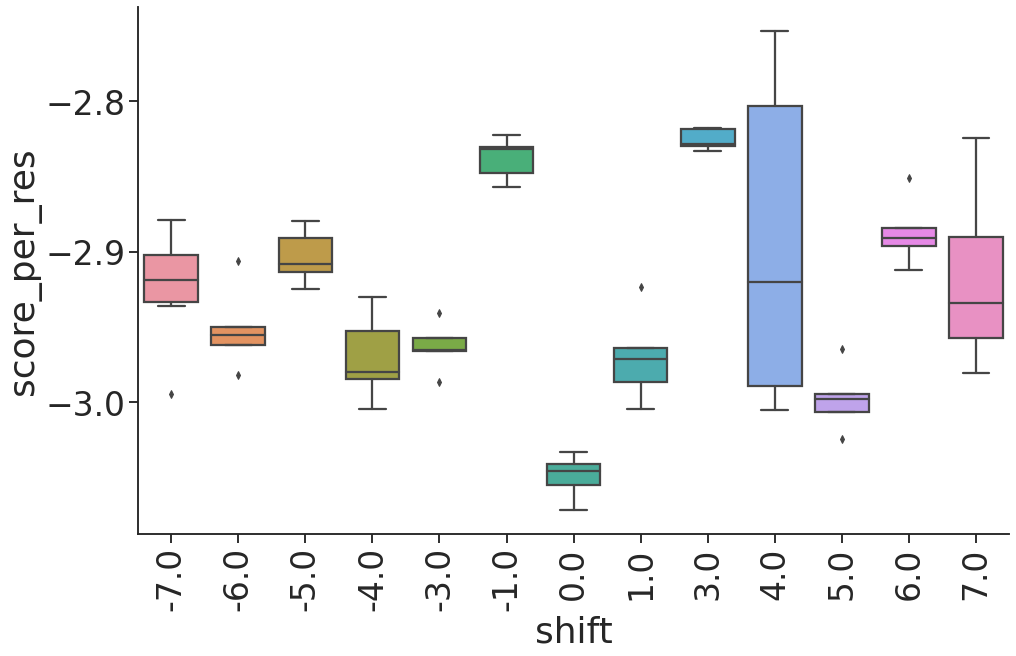

In [5]:
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
sns.set(
    context="talk",
    font_scale=2, # make the font larger; default is pretty small
    style="ticks", # make the background white with black lines
    palette="colorblind" # a color palette that is colorblind friendly!
)
   
fig = plt.figure(figsize=(15,10), tight_layout=True)
pivot_order = ['6', '7']
ax = sns.boxplot(
    x="shift", y="score_per_res", data=new_scores,
#     hue="pivot_helix", hue_order=pivot_order,
)
sns.despine()
# plt.setp(ax.get_legend().get_title(), fontsize='24')
plt.xticks(rotation=90)
plt.savefig("TH_parents.png")

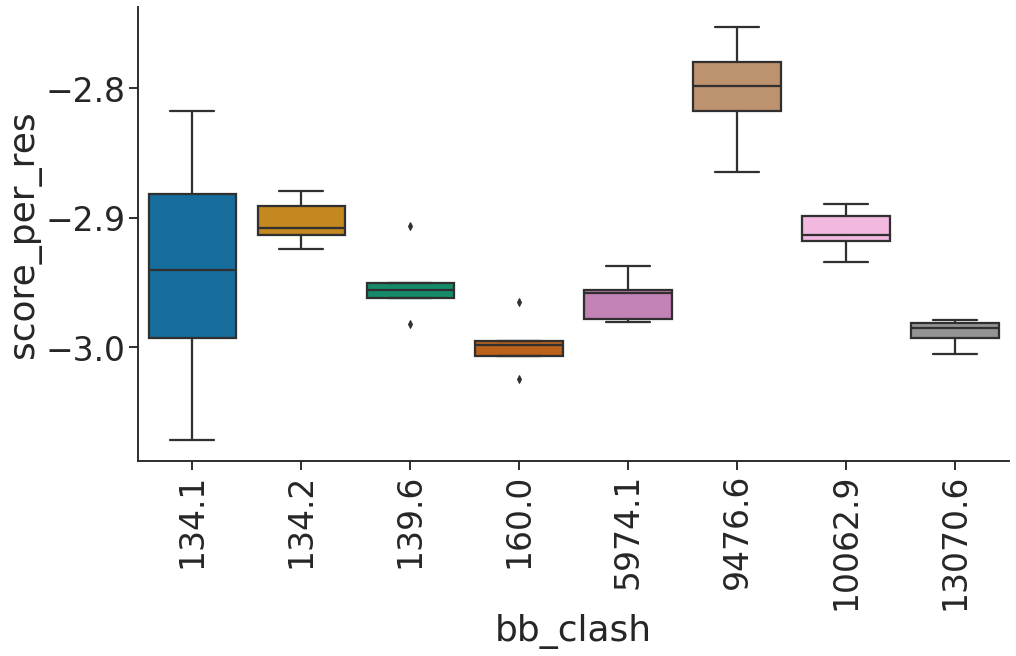

In [23]:
fig = plt.figure(figsize=(15,10), tight_layout=True)
ax = sns.boxplot(
    x="bb_clash", y="score_per_res", data=new_scores,
)
sns.despine()
plt.xticks(rotation=90)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels([str(round(float(label), 1)) for label in labels])
plt.savefig("TH_clash_vs_score.png")

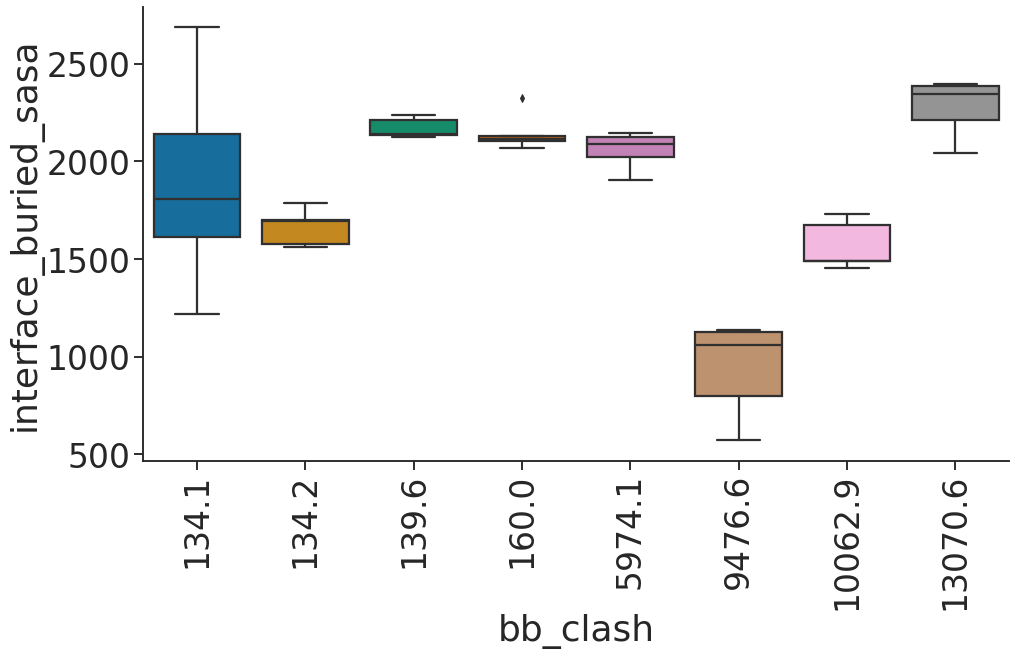

In [24]:
fig = plt.figure(figsize=(15,10), tight_layout=True)
ax = sns.boxplot(
    x="bb_clash", y="interface_buried_sasa", data=new_scores,
)
sns.despine()
plt.xticks(rotation=90)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels([str(round(float(label), 1)) for label in labels])
plt.savefig("TH_clash_vs_sasa.png")

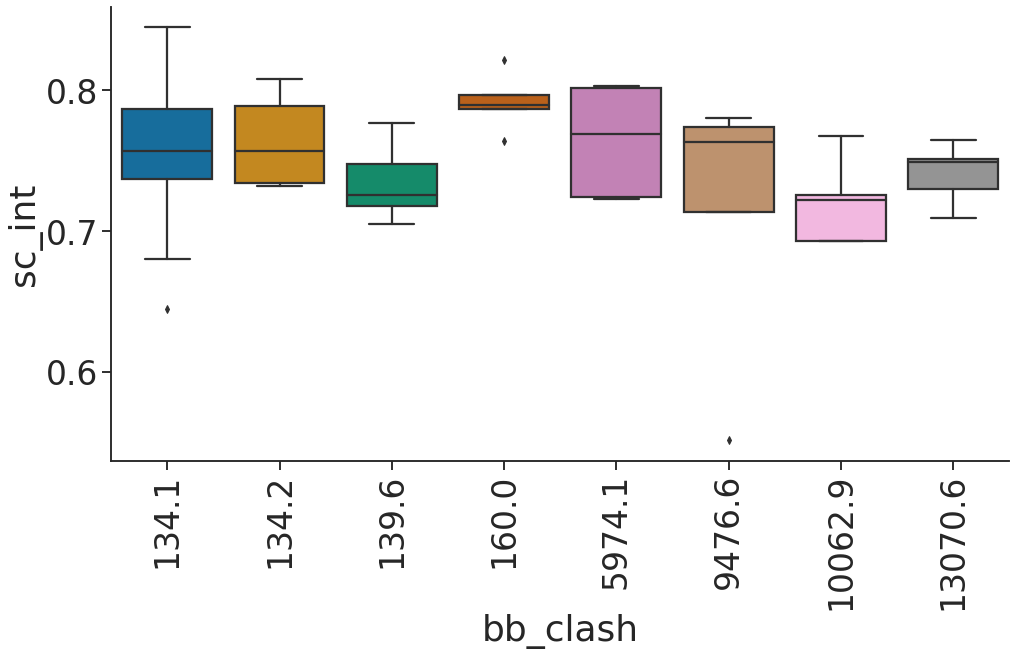

In [25]:
fig = plt.figure(figsize=(15,10), tight_layout=True)
ax = sns.boxplot(
    x="bb_clash", y="sc_int", data=new_scores,
)
sns.despine()
plt.xticks(rotation=90)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels([str(round(float(label), 1)) for label in labels])
plt.savefig("TH_clash_vs_sc_int.png")

# Get top 80% of decoys
interesting, flo was right, starting clash score doesnt seem to be predictive of final interface quality  
TODO, basically get top 80% for each parent as right now I am just doing it for a single one. probably can use a one liner groupby or somethign


In [27]:
total = len(new_scores)
not_worst = round(0.8*total)
sorted_decoys = new_scores.sort_values("score_per_res", ascending=True)

In [ ]:
selected = sorted_decoys.iloc[0:not_worst]
selected_decoys = list(selected.index)
for idx in selected_decoys:
    print(dict(selected.loc[idx]))

# This next part needs some work
TODO, parallelize this absolutely terrible code
TODO, doing it this way erases the score info as well >:(
TODO, add in parent silent name

In [41]:
import bz2
import pyrosetta.distributed.io as io
pyrosetta.init("-mute all")
if not os.getenv("DEBUG"):
    future_poses = []
    for i, bz2file in enumerate(tqdm(selected_decoys), start=1):
        with open(bz2file, "rb") as f:
            # decompress TODO use client
            future_pose = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
            future_poses.append(future_pose)
    packed_poses = []
    for future in future_poses:
        pose = io.to_pose(future)
        for key, value in dict(selected.loc[bz2file]).items():

            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)

        packed_poses.append(io.to_packed(pose))
               
io.to_silent(packed_poses, "test.silent")

  0%|          | 0/72 [00:00<?, ?it/s]

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


100%|██████████| 72/72 [01:55<00:00,  1.60s/it]


In [28]:
print(sys.getsizeof(packed_poses), "bytes used by all_poses")
packed_poses[0].pose.sequence()

1680 bytes used by all_poses


'LVEEAKKELEEEIERAKKKFSDGPPMLRKIIELVHKLAEAIIEQVPDPELARQIRKKVKEIAEELHKMRRRGHDLVEVAEKALEALIEIAKVAFSDGPPMLRKIIELVHELAEHIIKQVPDPELAEEILQHVVEVLKKLLEMRRRLVEVAEQALEDLIRIAEVAFSDGPPMLRKIIELVHELAKAIIEQVPDPRLARQILQAVVEILIKLLEMRRRGHDLVEVAEQALEALIEIAKVAFSDGPPMLRKIIELVHELAKAIIEQVPDPRLAREILELVVQVLIKLLEMRRRGHDLVEVAKEALKFLIRIAEVAFSDGPPVLRKIIELVHKLAEAIIEQVPDPELAEEILQAVVEALIKLLEMRRRGHDLVEVAREALKHLIEIAKVAFSDGPPEYRKRIEETHERAERRIKQVPDPEEAEEVLERAVEELIKALEKRRRGHD'